# Carnatic Beat Detection: what is that beat?


### Overview

This project develops an ML/AI classifier that identifies the Carnatic beat cycle (taalam) of a mridangam solo

### Background
In the South Indian classical music genre (also called Carnatic music), the concept of rhythm is very well developed and sophisticated. All songs follow a certain beat cycle called taalam. During a concert the percussionist, who typically plays a hand drum called mridangam, is given an opportunity to perform a drum solo, where he/she brings out the intricacies of the taalam of the preceding song. The solo can last from 5 to 10 minutes to as much as 30 to 40 minutes.


### Goal

Given a clip of a drum solo, identify the taalam (beat cycle) in which it is performed.

While there are 5 main taalam types that are commonly performed (and in principle thousands of possible taalams), I have restricted the scope of this project to 3 well-known and often-used taalams: aadi talam (8-beat cycle), mishra-chapu talam (7 beat cycle) and khanda-chapu talam (5-beat cycle).

### Data

In [278]:
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import seaborn as sns
import os
import random
import math

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, TargetEncoder, LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor, ColumnTransformer
from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression 
from sklearn.metrics import mean_squared_error, accuracy_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier

import time

In [279]:
# Load the data
beatsDf1 = pd.read_csv("data/Beats-3Class.csv")
beatsDf1.sample(7)

,FileName,Beat,1,2,3,4,5,6,7,8,...,491,492,493,494,495,496,497,498,499,500
103,KhandaChapu105,K,0.016016,0.018928,0.023005,0.025626,0.028829,0.031741,0.035236,0.037566,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,KhandaChapu2026,K,0.000579,0.003476,0.011587,0.014774,0.017961,0.021437,0.024913,0.028679,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,Aadi-1014,A,0.003482,0.006094,0.008416,0.011898,0.014219,0.017121,0.020023,0.022345,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,Palghat raghu misra chapu - 103,M,0.001448,0.004922,0.011581,0.014765,0.018240,0.025188,0.028662,0.031847,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,Aadi-1018,A,0.003757,0.006936,0.009827,0.012428,0.015896,0.018208,0.020231,0.024277,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,MisraChapu-1000,M,0.003764,0.007528,0.011870,0.013607,0.015924,0.019977,0.027504,0.032137,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76,MisraChapu-1024,M,0.018841,0.023188,0.025797,0.028696,0.031594,0.035942,0.037681,0.040580,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [280]:
beatsDf1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Columns: 502 entries, FileName to 500
dtypes: float64(500), object(2)
memory usage: 455.1+ KB


#### Cleanup 1:
We will set the number of numeric (time-lapse) features to be 250. Drop features with names > 250.

In [281]:
# We will drop features with names 251 -- 500
featuresToDrop = []
for nn in range(251, 501):
    featuresToDrop.append(str(nn))

In [282]:
# Drop the columns above
beatsDf1 = beatsDf1.drop(featuresToDrop, axis = 1)

In [283]:
beatsDf1.sample(7)

,FileName,Beat,1,2,3,4,5,6,7,8,...,241,242,243,244,245,246,247,248,249,250
84,KhandaChapu2014,K,0.000000,0.001158,0.003764,0.006080,0.009554,0.011870,0.015345,0.017082,...,0.736248,0.739143,0.741749,0.745223,0.749855,0.751882,0.755356,0.757672,0.760857,0.764621
42,MisraChapu-1008,M,0.000000,0.002064,0.009434,0.012677,0.020932,0.023880,0.026828,0.030366,...,0.854658,0.860554,0.863502,0.867630,0.872642,0.875295,0.880012,0.885024,0.887087,0.890920
28,Aadi-1028,A,0.000290,0.002899,0.005507,0.008696,0.011304,0.013913,0.016522,0.018261,...,0.885507,0.891304,0.898261,0.900290,0.901739,0.906087,0.909275,0.912754,0.914783,0.916232
72,MisraChapu-1020,M,0.001453,0.005520,0.009587,0.015979,0.019175,0.021499,0.023533,0.025276,...,0.750726,0.753632,0.757408,0.762057,0.764962,0.769030,0.770773,0.773097,0.776293,0.781522
55,UKS-KhandaChapu-101,K,0.001181,0.004135,0.009746,0.013881,0.018311,0.024808,0.030715,0.056999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,MisraChapu-1023,M,0.000000,0.003201,0.010186,0.013097,0.016007,0.019208,0.022410,0.024156,...,0.836729,0.840221,0.848370,0.851863,0.854482,0.862922,0.866997,0.869034,0.875146,0.879802
101,MishraChapu2001,M,0.000290,0.005217,0.008986,0.011014,0.013043,0.016522,0.018841,0.020580,...,0.753333,0.756522,0.759130,0.762029,0.764928,0.767536,0.770725,0.773623,0.775362,0.777101


In [284]:
beatsDf1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Columns: 252 entries, FileName to 250
dtypes: float64(250), object(2)
memory usage: 228.5+ KB


#### Cleanup 2:
Drop rows with NaNs. These are really short clips and probably will not contain sufficient data for analysis. There is no meaningful way to fill in missing values.

In [285]:
beatsDf = beatsDf1.dropna()

In [286]:
beatsDf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101 entries, 0 to 115
Columns: 252 entries, FileName to 250
dtypes: float64(250), object(2)
memory usage: 199.6+ KB


In [287]:
beatsDf.sample(5)

,FileName,Beat,1,2,3,4,5,6,7,8,...,241,242,243,244,245,246,247,248,249,250
16,Aadi-1016,A,0.000869,0.004922,0.006948,0.009554,0.012160,0.015345,0.019398,0.021424,...,0.761726,0.763463,0.765489,0.767516,0.769253,0.771280,0.773306,0.775043,0.776781,0.779097
23,Aadi-1023,A,0.001453,0.003777,0.007554,0.013655,0.017141,0.020628,0.024114,0.027891,...,0.852992,0.856479,0.864614,0.870134,0.872167,0.876235,0.879721,0.883498,0.887275,0.891633
43,MisraChapu-1009,M,0.011608,0.013639,0.017121,0.020023,0.024376,0.031050,0.034823,0.042658,...,0.931225,0.935287,0.939350,0.942542,0.945734,0.948636,0.953860,0.956181,0.959373,0.962855
25,Aadi-1025,A,0.000290,0.002613,0.004355,0.006969,0.011034,0.014228,0.016551,0.018873,...,0.796167,0.797909,0.802555,0.807491,0.813589,0.820267,0.822300,0.825203,0.828107,0.830139
107,KhandaChapu109,K,0.001450,0.004930,0.007251,0.011311,0.016531,0.018271,0.021752,0.027552,...,0.871520,0.876160,0.880220,0.882831,0.885441,0.890081,0.892401,0.895302,0.898202,0.900522


In [288]:
# Drop the "FileName" column
beatsDf = beatsDf.drop("FileName", axis = 1)

In [289]:
beatsDf.value_counts('Beat')

Beat
A    36
M    34
K    31
Name: count, dtype: int64

In [290]:
# For the current state of the data, we have only one 'K' beat. 
#Drop it so that we have a 2-fold (binary) classification situation.
#beatsDf = beatsDf.drop(beatsDf[beatsDf.Beat == 'K'].index)

In [291]:
#beatsDf.value_counts('Beat')

### Split data into training and test sets

In [292]:
# Data: indepndent and dependent variables
X = beatsDf.drop(['Beat'], axis = 1)

# target
labelEnc = LabelEncoder()
y = labelEnc.fit_transform(beatsDf['Beat'])

In [293]:
# Preprocessing pipeline for numerical features: StandardScaler
numeric_feats = []
for nn in range(1, 251):
    numeric_feats.append(str(nn))    

In [294]:
preprocPipe = ColumnTransformer(
    transformers=[
        ('numeric', StandardScaler(), numeric_feats)
    ])

In [295]:
rand_state = 44
# Data, split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = rand_state)

#### KNN grid search for the n_neighbors hyperparameter

In [296]:
test_score_knn = {}
n_neighbors = np.arange(2, 51, 1)
for neighbor in n_neighbors:

    knn = KNeighborsClassifier(n_neighbors=neighbor)
    pipe = make_pipeline(preprocPipe, knn)
    pipe.fit(X_train, y_train)

 
    y_pred_knn = pipe.predict(X_test)
    score = accuracy_score(y_test, y_pred_knn)
    
    test_score_knn[neighbor] = score

best_nbrs_knn = max(test_score_knn, key = test_score_knn.get)
print('Optimal num neighbors = ' + str(best_nbrs_knn) + ', score =' + str(test_score_knn[best_nbrs_knn])) 

Optimal num neighbors = 6, score =0.5384615384615384


### Building a model for each classifier

In [297]:
# Model pipelines
logRegPipe = make_pipeline(preprocPipe, LogisticRegression(max_iter=10000, random_state = rand_state))
decTreePipe = make_pipeline(preprocPipe, DecisionTreeClassifier(random_state = rand_state))
knnPipe = make_pipeline(preprocPipe, KNeighborsClassifier(n_neighbors = best_nbrs_knn))
svmPipe = make_pipeline(preprocPipe, SVC(random_state = rand_state))
logRegCVPipe = make_pipeline(preprocPipe, LogisticRegressionCV(cv=5, random_state = rand_state, max_iter=10000))

pipelines = [logRegPipe, decTreePipe, knnPipe, svmPipe, logRegCVPipe]

### Model evaluation

In [298]:
# Evaluating the models
model_performance = []

for pipe in pipelines:
        #Start a timer
        start_time = time.time()
        
        # fit the data
        pipe.fit(X_train, y_train)
        
        #End the timer, get elapsed time
        end_time = time.time()
        fit_time = end_time - start_time

        # Make a prediction, measure the accuracy
        y_pred = pipe.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        
        modelName = type(pipe._final_estimator).__name__

        model_performance.append({
            'Model': modelName,
            'Score': score,
            'Time': fit_time
            })
        

In [299]:

# Dataframe out of the results
performDf = pd.DataFrame(model_performance)

In [300]:
performDf

,Model,Score,Time
0,LogisticRegression,0.500000,0.062830
1,DecisionTreeClassifier,0.461538,0.036868
2,KNeighborsClassifier,0.538462,0.011968
3,SVC,0.384615,0.011968
4,LogisticRegressionCV,0.346154,1.773256


### Ensemble classifiers

#### BaggingClassifier with n_estimators hyperparameter tuning

In [301]:
test_score_bg = {}
fit_time_bg = {}
n_estimators = np.arange(500, 5001, 500)
for estimator in n_estimators:

    bgClassifier = BaggingClassifier(DecisionTreeClassifier(random_state = rand_state), n_estimators = estimator, oob_score = True)
    bgClassifierPipe = make_pipeline(preprocPipe, bgClassifier)

    #Start a timer
    start_time = time.time()
            
    bgClassifierPipe.fit(X_train, y_train)
    
    #End the timer, get elapsed time
    end_time = time.time()
    fit_time = end_time - start_time
    
    y_pred_bg = bgClassifierPipe.predict(X_test)
    score_bg = accuracy_score(y_test, y_pred_bg)
    
    test_score_bg[estimator] = score_bg
    fit_time_bg[estimator] = fit_time


In [302]:
best_nEstimators_bg = max(test_score_bg, key = test_score_bg.get)
print('Optimal num estimators = ' + str(best_nEstimators_bg) + ', score =' + str(test_score_bg[best_nEstimators_bg]) + 
      ', time =' + str(fit_time_bg[best_nEstimators_bg]))

# Append to performDf
performDf.loc[len(performDf.index)] = ['Bagging', test_score_bg[best_nEstimators_bg], 
                                       fit_time_bg[best_nEstimators_bg]] 

Optimal num estimators = 500, score =0.46153846153846156, time =8.572909355163574


#### RandomForest with n_estimators (trees) hyperparameter tuning

In [303]:
n_trees = [2, 4, 8, 16, 32, 64]
test_score_rf = {}
fit_time_rf = {}
for tr in n_trees:
    rforest = RandomForestClassifier(random_state=rand_state, max_depth = 50, n_estimators = tr)
    rfPipe = make_pipeline(preprocPipe, rforest)
    
    #Start a timer
    start_time = time.time()
    
    rfPipe.fit(X_train, y_train)
    
    #End the timer, get elapsed time
    end_time = time.time()
    fit_time = end_time - start_time
        
    y_pred_rf = rfPipe.predict(X_test)
    score_rf = accuracy_score(y_test, y_pred_rf)
    
    test_score_rf[tr] = score_rf
    fit_time_rf[tr] = fit_time


In [304]:
best_nTrees_rf = max(test_score_rf, key = test_score_rf.get)
print('Optimal num trees = ' + str(best_nTrees_rf) + ', score =' + str(test_score_rf[best_nTrees_rf]) +
     ', time =' + str(fit_time_rf[best_nTrees_rf])) 

# Append to performDf
performDf.loc[len(performDf.index)] = ['RandomForest', test_score_rf[best_nTrees_rf], 
                                       fit_time_rf[best_nTrees_rf]] 

Optimal num trees = 4, score =0.5384615384615384, time =0.019950389862060547


#### AdaBoost with n_estimators and depth hyperparameter tuning

In [305]:
# Run a GridSearchCV to get the optimal ada classifier
import warnings
warnings.filterwarnings('ignore')

ada_params = {'n_estimators': [100, 150, 200, 250, 300],
              'base_estimator__max_depth': [3, 4, 5, 6, 7]}
ada_tree_grid = GridSearchCV(AdaBoostClassifier(base_estimator = DecisionTreeClassifier(), random_state = rand_state), 
                             param_grid = ada_params2)
ada_tree_grid.fit(X_train, y_train)
ada_acc = ada_tree_grid.score(X_test, y_test)

In [306]:
print('ada_acc =' + str(ada_acc))
ada_best_params = ada_tree_grid.best_params_
print(ada_best_params)

ada_acc =0.5384615384615384
{'base_estimator__max_depth': 5, 'n_estimators': 200}


In [307]:
# Run the optimal classifier and get performance metrics
ada = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = ada_best_params['base_estimator__max_depth']), 
                         random_state = rand_state, 
                         n_estimators = ada_best_params['n_estimators'])
adaPipe = make_pipeline(preprocPipe, ada)

#Start a timer
start_time_ada = time.time()
adaPipe.fit(X_train, y_train)
    
#End the timer, get elapsed time
fit_time_ada = time.time() - start_time_ada

y_pred_ada = adaPipe.predict(X_test)
score_ada = accuracy_score(y_test, y_pred_ada)

# Append to performDf
performDf.loc[len(performDf.index)] = ['AdaBoost', score_ada, fit_time_ada]


In [308]:
performDf

,Model,Score,Time
0,LogisticRegression,0.500000,0.062830
1,DecisionTreeClassifier,0.461538,0.036868
2,KNeighborsClassifier,0.538462,0.011968
3,SVC,0.384615,0.011968
4,LogisticRegressionCV,0.346154,1.773256
5,Bagging,0.461538,8.572909
6,RandomForest,0.538462,0.019950
7,AdaBoost,0.538462,7.336270


In [309]:
# Plot model vs accuracy
#pFig1 = px.bar(performDf, x = 'Model', y = 'Score', color = 'Model')
#pFig1.update_layout(
#            title={
#            'text' : 'Model Accuracy',
#            'x':0.4,
#            'xanchor': 'center'
#        })
#pFig1.show()
# Note: We suppress the plotly graph and use sns below for the saved notebook
#       so that when opened without execution the plot is visible

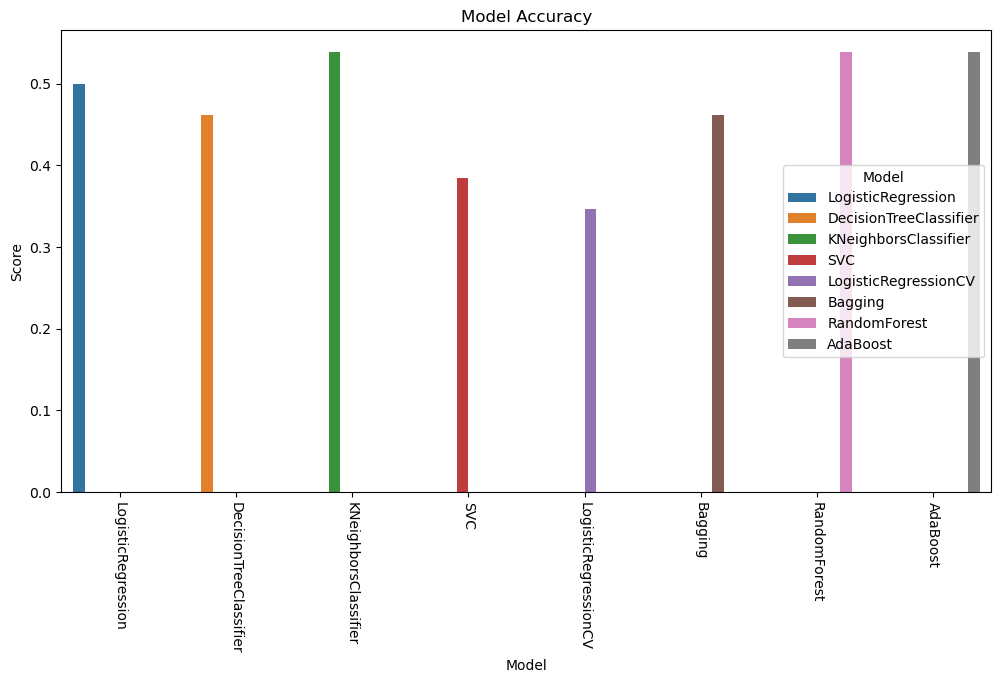

In [310]:
# Plot model vs accuracy
figg, axx = plt.subplots(figsize=(12, 6))
# Plot model vs accuracy
snsF1 = sns.barplot(performDf, x = 'Model', y = 'Score', hue = 'Model')
snsF1.set_title('Model Accuracy')
snsF1.tick_params(axis='x', rotation = -90)
sns.move_legend(snsF1, "center right")
snsF1.get_figure().savefig('./images/Model_vs_accuracy_sns.png')

In [311]:
# Plot model vs time
#pFig2 = px.bar(performDf, x = 'Model', y = 'Time', color = 'Model',
#                labels = {
#                     "Model": "Model",
#                     "Time": "Time (seconds)",
#                 })

#pFig2.update_layout(
#            title={
#            'text' : 'Model Computation Time',
#            'x':0.4,
#            'xanchor': 'center'
#        })
#pFig2.show()
# Note: We suppress the plotly graph and use sns below for the saved notebook
#       so that when opened without execution the plot is visible

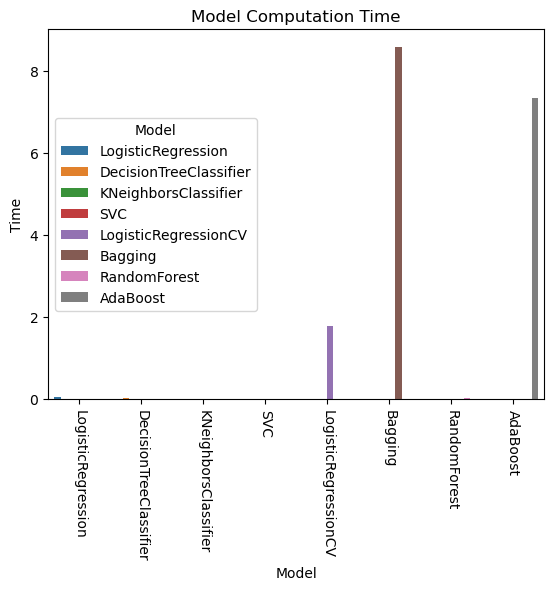

In [312]:
# Plot model vs time
snsF2 = sns.barplot(performDf, x = 'Model', y = 'Time', hue = 'Model')
snsF2.set_title('Model Computation Time')
snsF2.tick_params(axis='x', rotation = -90)
sns.move_legend(snsF2, "center left")
snsF1.get_figure().savefig('./images/Model_vs_time_sns.png')

### Evaluation

#### Model Accuracy
Some models fared better than random chance (0.33) but none were very impressive. The best scores were from ensemble classifiers, close to 0.6 (almost twice as good as random chance). KNN also had a similar accuracy. More data is needed to make definitive conclusions about model accuracy.

#### Computation time

KNearestNeighbors was the speediest, and was also among the top performers accuracy-wise.

#### Caveat
The above analysis was done with a very small dataset! The results might change as more data is generated and brought into the analysis.